## UDD - Instituto de Data Science 
### MDS-18
### Evaluación Introducción a la Visión Computacional

Profesora: 
- Opitz, Daniela

Alumnos:
- Briceño, Heriberto
- Rovai, Marcelo
- Sacasa, Manuel

<p>Santiago, 11 de Noviembre 2018</p>

---

#### Importar bibliotecas importantes

In [1]:
import os
import cv2
import pickle
import argparse
from imutils import paths, build_montages
import face_recognition
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
%matplotlib inline

## 1. RGB

**1. El archivo imagenes1.zip contiene seis imágenes con los canales R, G, B
separados y desalineados. Elija tres de ellas para recortar y separar los
canales R, G, B y alinearlos para obtener una imagen a color lo más nítida
posible. Para ello siga los siguientes pasos:**

**1.1. Cree una función que reciba la lista de imágenes y las visualice sin ningún
procesamiento previo y utilícela para explorar las imágenes a recortar y
alinear. Todas las imágenes deben ser desplegadas en el mismo gráfico.**

In [2]:
def view_images(image_file_path, num=3):
    '''
    Recibe un path de donde están armazenadas las 
    imágenes RGB originales y las muestra de 3 en 3.
    '''
    plt.figure(figsize=(8,8)) 
    imagePaths = list(paths.list_images(image_file_path))
    num_img = len(imagePaths) 
    print("Numero de imagenes:", num_img)

    for i in range (0, num_img):
        plt.subplot((num_img//num)+1, num, i+1)
        img = cv2.imread(imagePaths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title("img {}".format(i))
        plt.tight_layout()
        plt.imshow(img)

#### Verificar las imagenes 

Numero de imagenes: 3


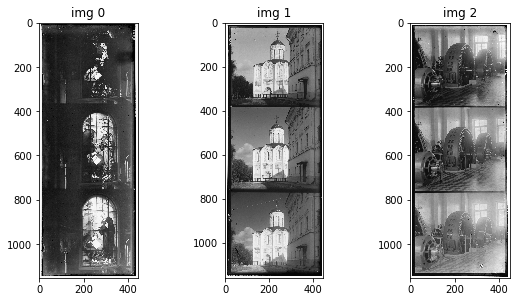

In [7]:
view_images("./imagenes1")

La función fue desarrollada para que desplegue las imagenes de un dado archivo, por default de "3 en 3", por ejemplo se en el folder hay 10 imagenes, 4 lineas son desplegadas, 3 con 3 imagenes y una con 1 a penas. Para otras cantidades de imagenes por linea, se puede cambiar el valor del parametro "num" en la función. la base para desplegar todas las figuras en un mismo grafico es el "subplot": <br> `plt.subplot((num_img//num)+1, num, i+1)`

**1.2. Cree una función que corte cada imagen en tres para obtener los canales
R, G y B y los combine para obtener una imagen a color sin utilizar
técnicas para alinear los canales**

In [8]:
def trim_img(img, dt, db, dl, dr):
    sz = img.shape
    img = img[int(sz[0]*dt):int(sz[0]*db) , int(sz[1]*dl):int(sz[1]*dr)]
    return img

In [14]:
def draft_RGB_color (img):
    '''
    Recibe una imagen separada en canales RGB y
    la retorna convertida a color (Draft).
    '''
    im_grey =  cv2.imread(img, cv2.IMREAD_GRAYSCALE);
    sz = im_grey.shape
    height = int(sz[0] / 3);
    width = sz[1]
    im_color = np.zeros((height,width,3), dtype=np.uint8 )
    im_color.shape
    for i in range(0,3):
        im_color[:,:,i] = im_grey[i*height:(i+1) * height,:]   
    im_color = trim_img(im_color, 0.07, 0.93, 0.09, 0.91)    
    return im_color

In [10]:
def create_view_draft_color_img(image_file_path):
    '''
    Recibe un path de donde están las imágenes RGB,
    las salva en un nuevo folder y las muestra de 3 en 3.
    '''
    imagePaths = list(paths.list_images(image_file_path))
    num_img = len(imagePaths)
    for i in range (0, num_img):
        cv2.imwrite(image_file_path+"_out/"+str(i)+".jpg", draft_RGB_color (imagePaths[i]))   
    view_images(image_file_path+"_out")

Numero de imagenes: 3


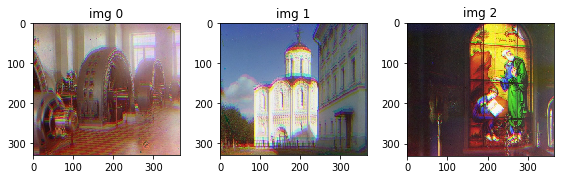

In [15]:
create_view_draft_color_img("./imagenes1")

La funcion principal `create_view_draft_color_img(image_file_path)`, recibe un path del folder donde están las imágenes RGB, las salva en un nuevo folder y las muestra de 3 en 3 by default llamando la función `view_images(image_file_path, num=3)` (Esta cantidad puede ser cambiada, como explicado en el topico anterior). Esta función carrega la lista de imagenes y llama la función auxiliar `draft_RGB_color (img)`, la cual separa la imagen en sus 3 canales R, G y B, y los "monta"simplesmente, sobreponiendo las imagenes una sobre la otra, generando un borrador de imagenen a color. Antes de retornar la imagen a color, la función `trim_img(img, dt, db, dl, dr)` es llamada para se "cortar las bordas de la imagen para una mejor visualización (en este ejemplo se cortó 7% para las bordas horizontales (altura) y 9% para las bordas verticales (ancho). Observe que todas las imagenes RGB originales del folder `./imagenes1` serán convertidas a; borrador a color y armazenadas en un folder `./imagenes1_out`. Este folder deberá ser creado anteriormente al uso de la función. 

**1.3. Cree una función que retorne las imágenes a color alineadas lo mejor
posible. Si remueve los bordes, alinear las imágenes será más sencillo.**

In [17]:
def get_gradient(im) :
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

In [18]:
def final_RGB_color(img):
    '''
    Recibe una imagen separada en canales RGB y
    la retorna convertida a color (Final).
    '''
    warp_mode = cv2.MOTION_HOMOGRAPHY
    im_grey =  cv2.imread(img, cv2.IMREAD_GRAYSCALE);

    sz = im_grey.shape    
    height = int(sz[0] / 3)
    width = sz[1]
    im_color = np.zeros((height,width,3), dtype=np.uint8 )
    im_color.shape
    for i in range(0,3):
        im_color[:,:,i] = im_grey[i*height:(i+1) * height,:]

    im_color_grad = np.zeros((height,width,3), dtype=np.uint8 )

    for i in range(0,3):
        im_color_grad[:,:,i]=get_gradient(im_color[:,:,i])
    im_color
    im_aligned = np.zeros((height,width,3), dtype=np.uint8 )
    im_aligned[:,:,2] = im_color[:,:,2]

    warp_matrix = np.eye(3, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

    for i in range(0,2):
        (cc, warp_matrix) = cv2.findTransformECC (im_color_grad[:,:,2], im_color_grad[:,:,i], warp_matrix, warp_mode, criteria)
        im_aligned[:,:,i] = cv2.warpPerspective (im_color[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    im_aligned = trim_img(im_aligned, 0.07, 0.93, 0.09, 0.91) 
    return im_aligned

In [19]:
def create_view_final_color_img(image_file_path):
    '''
    Recibe un path de donde están las imágenes RGB,
    las salva en un nuevo folder y las muestra de 3 en 3.
    '''
    imagePaths = list(paths.list_images(image_file_path))
    num_img = len(imagePaths)
    for i in range (0, num_img):
        cv2.imwrite(image_file_path+"_out/"+str(i)+".jpg", final_RGB_color (imagePaths[i]))   
    view_images(image_file_path+"_out")

Numero de imagenes: 3


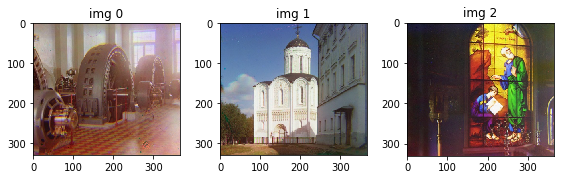

In [20]:
create_view_final_color_img("./imagenes1")

La funcion principal `create_view_final_color_img(image_file_path)`, recibe un path del folder donde están las imágenes RGB, las salva en un nuevo folder y las muestra de 3 en 3 by default llamando la función `view_images(image_file_path, num=3)` (Esta cantidad puede ser cambiada, como explicado en un topico anterior). Esta función carrega la lista de imagenes y llama la función auxiliar `final_RGB_color(img)`, la cual separa la imagen en sus 3 canales R, G y B, y las "alinea" utilizando tecnicas mas sofisticadas que en la versión anterior, cuja base es `warp_mode = cv2.MOTION_HOMOGRAPHY`, generando una imagenen a color. Antes de retornar la imagen a color, la función `trim_img(img, dt, db, dl, dr)` es llamada para se "cortar las bordas de la imagen para una mejor visualización (en este ejemplo se cortó 7% para las bordas horizontales (altura) y 9% para las bordas verticales (ancho). Observe que todas las imagenes RGB originales del folder `./imagenes1` serán convertidas a; borrador a color y armazenadas en un folder `./imagenes1_out`. Este folder deberá ser creado anteriormente al uso de la función. 

Se puede comprovar por el resultado arriba, que las imagenes quedaron mucho mejores. Pero, es importante notar que varios minutos són necesários para se generar cada imagen en el ultimo caso. Para una primera vizualización del resulatado a color se sugiere utilizar la función ` create_view_draft_color_img(image_file_path)`, que es muy rápida. y una vez definda cuales són las imagenes a trabajar de manera definitiva, utilizar la función `create_view_final_color_img(image_file_path)`.

---

## 2. Face Recognition & DBSCAN

**2. El archive imagenes2.zip contiene 129 imágenes de futbolistas famosos. Hay N futbolistas diferentes donde N es desconocido y N y menor a 129 . Esto significa que hay varias imágenes para el mismo futbolista. Clusterice el set de imágenes y asígnele un ID siguiendo los siguientes pasos**

#### Dataset para uso en la etapa de desarrollo de las funciones

Se generó um pequenõ subset de imagenes como test durante el desarrollo de las funciones. Una vez que las funciones estaban OK, se procedió a trabajar con el dataset completo. 

Numero de imagenes: 10


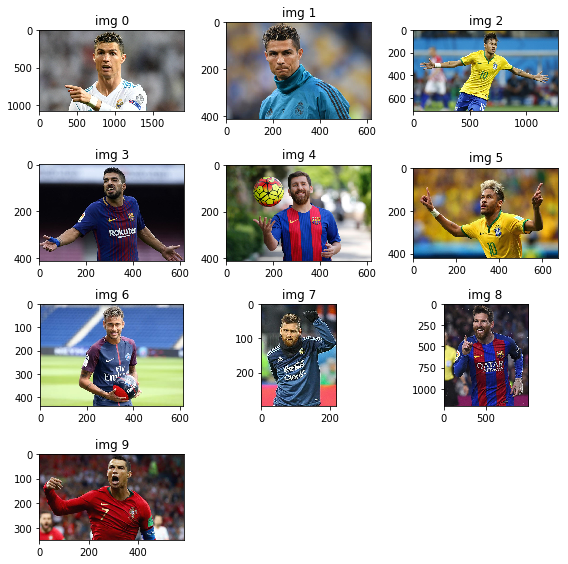

In [11]:
view_images("./test")

#### Verificar las imagenes a las que queremos extraer un vector

In [131]:
imagePaths = list(paths.list_images('./imagenes2'))
print("Numero de imagenes:", len(imagePaths))

Numero de imagenes: 129


Se desarrolló una función para desplegar las imagenes una a una en su forma original `show_images(imagePaths)`. Es una función opcional. 

In [148]:
def show_images(imagePaths): 
    '''
    Recibe una lista de imágenes [imagePaths] 
    y las visualiza 1 por linea (original).
    '''
    for (i, imagePath) in enumerate(imagePaths):
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()

## Detectando las caras y creando dataset

**2.1. Use la librería face_recognition, detecte las caras en cada imagen y genere un vector de características para cada cara. Entregue un archivo que describa el nombre de la imagen, la localización de la cara y el vector de características**

#### Definir metodo de detectción

La libreria `face_recognition`, permite dos metodos de detección de la cara `"Convolutional Neural Network (CNN)" o "Histogram of Oriented Gradients (HOG)"`. CNN es mucho mas precisa pero demorada encuanto HOG es rapida pero no tan precisa. El modelo debe ser definido en la línea de código: `boxes = face_recognition.face_locations(rgb,model = detection_method)`. A función `detect_face(imagePaths, detection_method, file_name)`, tomará las imagenes desde una lista de imagenes y generará un archivo ('filename'), el cual posue las informaciones de las características de cada cara detectada.

In [17]:
def detect_face(imagePaths, detection_method, file_name='detected_imgs'):      
        data = []

        for (i, imagePath) in enumerate(imagePaths):
            print("Procesando imagen {}/{}".format(i + 1,len(imagePaths)))
            print(imagePath)
            image = cv2.imread(imagePath)
            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            boxes = face_recognition.face_locations(rgb,model = detection_method) #Detectando las caras

            #Creando los vectores
            encodings = face_recognition.face_encodings(rgb, boxes)

            # Construyendo un diccionario con en el nombre de la imagen, el lugar donde esta la cara y el 
            # vector de caracteristicas
            d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
                for (box, enc) in zip(boxes, encodings)]
            data.extend(d)

        # Guardando los vectores en un formato en que no me importa la serializacion
        f = open(file_name, "wb")
        f.write(pickle.dumps(data))
        f.close()

In [228]:
detection_method = 'cnn' # HOG es mas rapido, pero menos preciso
file_name = 'encodings'

In [175]:
detect_face(imagePaths, detection_method, file_name)

Procesando imagen 1/129
./imagenes2/00000038.jpg
Procesando imagen 2/129
./imagenes2/00000010.jpg
Procesando imagen 3/129
./imagenes2/00000004.jpg
Procesando imagen 4/129
./imagenes2/00000005.jpg
Procesando imagen 5/129
./imagenes2/00000011.jpg
Procesando imagen 6/129
./imagenes2/00000039.jpg
Procesando imagen 7/129
./imagenes2/00000007.jpg
Procesando imagen 8/129
./imagenes2/00000013.jpg
Procesando imagen 9/129
./imagenes2/00000012.jpg
Procesando imagen 10/129
./imagenes2/00000006.jpg
Procesando imagen 11/129
./imagenes2/00000002.jpg
Procesando imagen 12/129
./imagenes2/00000016.jpg
Procesando imagen 13/129
./imagenes2/00000017.jpg
Procesando imagen 14/129
./imagenes2/00000003.jpg
Procesando imagen 15/129
./imagenes2/00000015.jpg
Procesando imagen 16/129
./imagenes2/00000001.jpg
Procesando imagen 17/129
./imagenes2/00000029.jpg
Procesando imagen 18/129
./imagenes2/00000028.jpg
Procesando imagen 19/129
./imagenes2/00000000.jpg
Procesando imagen 20/129
./imagenes2/00000014.jpg
Procesand

### Unpickling dataset y verificando caras

In [226]:
data = pickle.loads(open('encodings', "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
print("Numero de detecciones:", len(imagePaths))

Numero de detecciones: 129


`Con el método CNN, de detectarón 127 "caras", sendo que con HOG fueron 132. Se observa así que hay algunas caras que fueron detectadas erroneamente con HOG, pero no CNN. Esto es de se esperar pues el metodo HOG, es menos preciso, pero rápido (30' versus 1 hora)`

In [178]:
data[0]['imagePath']

'./imagenes2/00000038.jpg'

In [179]:
data[0]['loc']

(169, 1218, 373, 1014)

Se desarrolló dos funciones auxiliares, `show_face(img_id)` y `show_faces(data)`. La base de las dos es lo mismo. a partir de la localización de la cara detectada ("t:top, r:right, b:bellow y l:left"), `t,r,b,l = data[img_id]["loc"]`, se hace un "trim" de la image: `plt.imshow(img[t:b , l:r])`.

In [16]:
def show_face(img_id): 
    img = cv2.imread(data[img_id]['imagePath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    t,r,b,l = data[img_id]["loc"]
    plt.imshow(img[t:b , l:r])

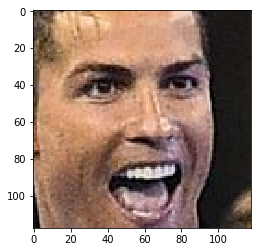

In [180]:
show_face(1)

In [15]:
def show_faces(data): 
    for i in range(len(data)):
        img = cv2.imread(data[i]['imagePath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        t,r,b,l = data[i]["loc"]
        plt.imshow(img[t:b , l:r])
        plt.show()

---

## Clustering dataset (con DBSCAN)

**2.2. Utilice los vectores de características para agrupar las caras de los futbolistas utilizando el algoritmo DBSCAN. Cada grupo corresponderá a un futbolista . Si usted conoce a los futbolistas pueden reemplazar los típicos IDS generados (0, 1, 2, 3 ...) por sus nombres.**

#### Definir modelo y aplicarlo al dataset

In [271]:
model = DBSCAN()
model.fit(encodings)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

**2.3. Indique cuantos futbolistas distintos (numero de clústeres) hay en el data set.**

#### Determinar el número de caras únicas en el dataset

In [272]:
label_ids = np.unique(model.labels_)
uniqueFaces = len(np.where(label_ids > -1)[0])
print("Número de caras únicas encontradas: {}".format(uniqueFaces))

Número de caras únicas encontradas: 5


`El modelo de clusterización a ser utilizado es DBSCAN. La gracia dete modelo es que el numero de clusters es desconocido en princiípio. Una vez que el modelo es palicado al archivo encontrado en la etapa anterior, se puede determinar el "Número de caras únicas encontradas", que són los clusters encontrados por el modelo. En el caso las caras únicas són 5.`

**2.4. Genere una forma de visualizar los clústeres. Para esto extraiga cada cara de cada imagen y despliéguela en grupo. Despliegue hasta un máximo de 5 caras por grupo, ignore el resto. Cambie el tamaño de las imágenes para visualizar inteligentemente. Recuerde que en archivo generado en 2.1 existe esa información.**

Para desplegar las caras en sus respectivos clusters, primero se desarrolló una función llamada `create_thumbnail(data, img_id)`, la cual a partir de un conjunto de caras detectadas, genera una lista de "thumbnails", pequenas figuras de las caras (el default es 128x128 pixels). 

In [17]:
def create_thumbnail(data, img_id, x=128, y=128):    
    faces = []
    for i in img_id:
        image = cv2.imread(data[i]["imagePath"])
        (t, r, b, l) = data[i]["loc"]
        face = image[t:b, l:r]
        face = cv2.resize(face, (x, y))
        faces.append(face)
    return faces

'A partir de una lista con los thumbnails de las caras se creo un "montage" llamando la función `create_montage(faces, rows=1, cols=5)`. Esta función llama por su vez la función `build_montages(faces, (x, y), (cols, rows))`, la cual es parte de la libreria `imutils`.

In [14]:
 def create_montage(faces, rows=5, cols=6, x=128, y=128):
        montage = build_montages(faces, (x, y), (cols, rows))[0]
        montage = cv2.cvtColor(montage, cv2.COLOR_BGR2RGB)
        return montage

#### Agrupar imagenes en los clusters encontrados

Total de 26 images encontradas en el Cluster #0


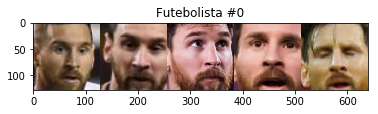

Total de 26 images encontradas en el Cluster #1


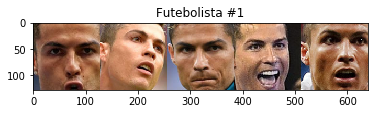

Total de 30 images encontradas en el Cluster #2


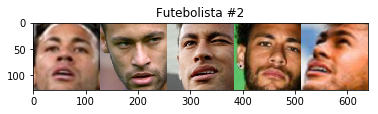

Total de 25 images encontradas en el Cluster #3


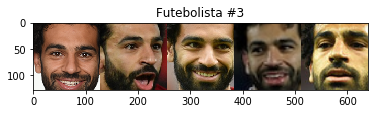

Total de 19 images encontradas en el Cluster #4


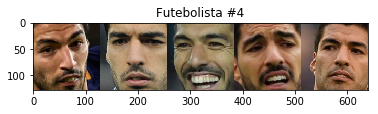

In [279]:
for label_id in label_ids:
    if label_id > -1:       
        img_id = np.where(model.labels_ == label_id)[0]
        img_id = np.random.choice(img_id, size=min(30, len(img_id)),replace=False)
        print("Total de {} images encontradas en el Cluster #{}".format(len(img_id), label_id))

        faces = create_thumbnail(data, img_id)
        title = "Futebolista #{}".format(label_id)
        
        plt.title(title)
        view_clusters = create_montage(faces, rows=1, cols=5)

        plt.imshow(view_clusters)
        plt.show()

`Por las amuestras arriba se puede identificar claramente quién són los futebolistas. `
- 0: 'Leonel Messi'
- 1: 'Cristiano Ronaldo', 
- 2: 'Neymar Junior', 
- 3: 'Mohamed Salah', 
- 4: 'Luis Suarez'

**2.5. En el set de imágenes hay un futbolista que no podrá ser identificado porque no pertenecerá a ningún clúster (outlier). Despliegue su cara**

Total de 1 images encontradas en el Cluster #-1


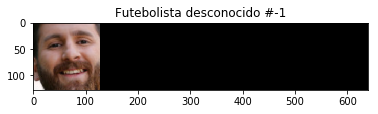

In [280]:
for label_id in label_ids:
    if label_id == -1:
        img_id = np.where(model.labels_ == label_id)[0]
        img_id = np.random.choice(img_id, size=min(30, len(img_id)),replace=False)
        print("Total de {} images encontradas en el Cluster #{}".format(len(img_id), label_id))

        faces = create_thumbnail(data, img_id)
        title = "Futebolista desconocido #{}".format(label_id)
        
        plt.title(title)
        view_clusters = create_montage(faces, rows=1, cols=5)

        plt.imshow(view_clusters)
        plt.show()

`Encontrando la imagen original`

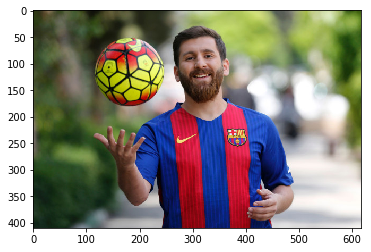

In [281]:
img = data[img_id[0]]["imagePath"]
img = cv2.imread(data[img_id[0]]["imagePath"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

`En una primera vista parece ser una imagen de Leonel Messi (Futebolista #0). Por que el programa no lo clasificó así? Sería una foto Fake? Un doble de Messi? Verifiquemonos la foto en el servicio de busca de imagenes de google: https://images.google.com/` 

Sí, la foto es de una persona otra que no Messi, su nombre es Reza Parastesh, un estudante Irani:<br>
https://www.nytimes.com/2017/05/09/sports/soccer/he-looks-like-lionel-messi-close-enough-to-get-him-detained.html

---

**2.6. Usted puede generar su propio set de datos. Si en vez de utilizar el set de
datos entregado en clases genera su propio set de imágenes remplazando la categoría de futbolista con políticos, actores, integrantes de su familia o fotografías de los integrantes del grupo en diferentes circunstancias recibirá puntuación extra.**

#### Verificar las imagenes a las que queremos extraer un vector

In [125]:
imagePaths = list(paths.list_images('./imagenes3'))
print("Numero de imagenes:", len(imagePaths))

Numero de imagenes: 101


#### Definir metodo de deteción y proceeder la detección de las caras

In [42]:
detection_method = 'cnn' # HOG es mas rapido, pero menos preciso, 'CNN' preciso pero demorado
file_name = 'encodings2_cnn'

In [43]:
detect_face(imagePaths, detection_method, file_name)

Procesando imagen 1/101
./imagenes3/47.jpeg
Procesando imagen 2/101
./imagenes3/10.jpeg
Procesando imagen 3/101
./imagenes3/51.jpeg
Procesando imagen 4/101
./imagenes3/92.jpeg
Procesando imagen 5/101
./imagenes3/84.jpeg
Procesando imagen 6/101
./imagenes3/26.jpeg
Procesando imagen 7/101
./imagenes3/71.jpeg
Procesando imagen 8/101
./imagenes3/88.jpeg
Procesando imagen 9/101
./imagenes3/67.jpeg
Procesando imagen 10/101
./imagenes3/30.jpeg
Procesando imagen 11/101
./imagenes3/31.jpeg
Procesando imagen 12/101
./imagenes3/89.jpeg
Procesando imagen 13/101
./imagenes3/66.jpeg
Procesando imagen 14/101
./imagenes3/70.jpeg
Procesando imagen 15/101
./imagenes3/27.jpeg
Procesando imagen 16/101
./imagenes3/85.jpeg
Procesando imagen 17/101
./imagenes3/1.jpeg
Procesando imagen 18/101
./imagenes3/93.jpeg
Procesando imagen 19/101
./imagenes3/50.jpeg
Procesando imagen 20/101
./imagenes3/11.jpeg
Procesando imagen 21/101
./imagenes3/46.jpeg
Procesando imagen 22/101
./imagenes3/20.jpeg
Procesando imagen 23

**Unpickling dataset y verificando caras**

In [44]:
data = pickle.loads(open('encodings2_cnn', "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
print("Numero de detecciones:", len(imagePaths))

Numero de detecciones: 101


**Definir modelo de clusterización y aplicarlo al dataset**

In [46]:
model = DBSCAN()
model.fit(encodings)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

**Determinar el número de caras únicas en el dataset**

In [47]:
label_ids = np.unique(model.labels_)
uniqueFaces = len(np.where(label_ids > -1)[0])
print("Número de caras únicas encontradas: {}".format(uniqueFaces))

Número de caras únicas encontradas: 8


**Agrupar imagenes en los clusters encontrados**

Total de 14 images encontradas en el Cluster #0


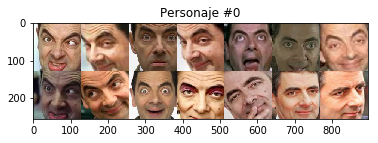

Total de 12 images encontradas en el Cluster #1


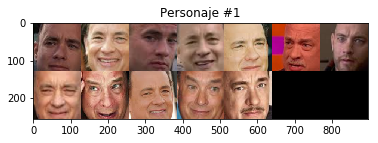

Total de 9 images encontradas en el Cluster #2


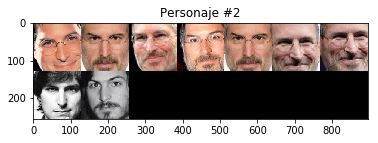

Total de 13 images encontradas en el Cluster #3


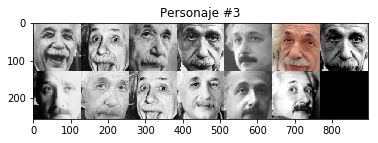

Total de 14 images encontradas en el Cluster #4


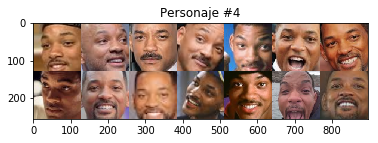

Total de 6 images encontradas en el Cluster #5


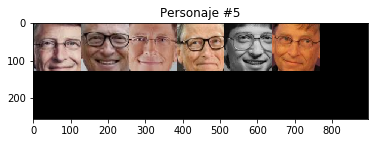

Total de 9 images encontradas en el Cluster #6


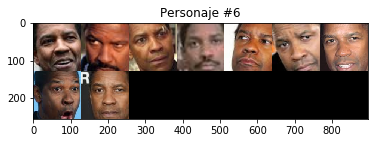

Total de 9 images encontradas en el Cluster #7


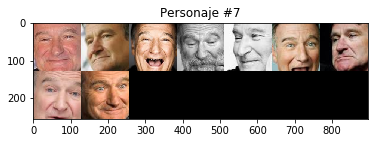

In [48]:
for label_id in label_ids:
    if label_id > -1:       
        img_id = np.where(model.labels_ == label_id)[0]
        img_id = np.random.choice(img_id, size=min(30, len(img_id)),replace=False)
        print("Total de {} images encontradas en el Cluster #{}".format(len(img_id), label_id))

        faces = create_thumbnail(data, img_id)
        title = "Personaje #{}".format(label_id)
        
        plt.title(title)
        view_clusters = create_montage(faces, rows=2, cols=7)

        plt.imshow(view_clusters)
        plt.show()

**Verificar outliers**

Total de 21 images encontradas en el Cluster #-1


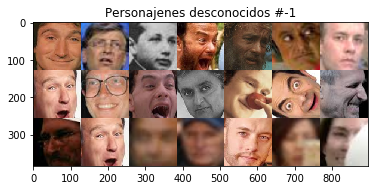

In [50]:
for label_id in label_ids:
    if label_id == -1:
        img_id = np.where(model.labels_ == label_id)[0]
        img_id = np.random.choice(img_id, size=min(30, len(img_id)),replace=False)
        print("Total de {} images encontradas en el Cluster #{}".format(len(img_id), label_id))

        faces = create_thumbnail(data, img_id)
        title = "Personajenes desconocidos #{}".format(label_id)
        
        plt.title(title)
        view_clusters = create_montage(faces, rows=3, cols=7)

        plt.imshow(view_clusters)
        plt.show()

### Conclusión

`Fue creado el nuevo dataset, pero con mas personajes, sendo que para cada personaje, habian pocas fotos. Además, las fotos són de baja resolución. Mesmo con todo esto, 8 clusters fueron detectados y todos os personajes en los clusters están corretos (80% de las fotos). 20% de las fotos fueron consideradas outliers. El ideal es tener al menos de 25 a 30 imagenes de cada personaje, como en el caso de los futebolistas.`